<a href="https://colab.research.google.com/github/park-jaehun/XAI/blob/main/Expedia_Travel_Dataset(%EC%9D%B4%EC%A7%84%EB%B6%84%EB%A5%98_%EC%98%88%EC%B8%A1%2Bshap).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 그래프 한글 패치 설치 및 설정
# -런타임 유형 다시 시작
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf


import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] =False

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

In [2]:
#2024.12.27
#  전기차 가격 예측
#0. 사용할 패키지 불러오기
import pandas as pd
import numpy as np

import seaborn as sns

In [3]:
travel_df = pd.read_csv('/content/drive/MyDrive/전기차 가격 예측(연습)/open (1)/travel.csv')
travel_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 25 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Unnamed: 0                 100000 non-null  int64  
 1   date_time                  100000 non-null  object 
 2   site_name                  100000 non-null  int64  
 3   posa_continent             100000 non-null  int64  
 4   user_location_country      100000 non-null  int64  
 5   user_location_region       100000 non-null  int64  
 6   user_location_city         100000 non-null  int64  
 7   orig_destination_distance  63915 non-null   float64
 8   user_id                    100000 non-null  int64  
 9   is_mobile                  100000 non-null  int64  
 10  is_package                 100000 non-null  int64  
 11  channel                    100000 non-null  int64  
 12  srch_ci                    99878 non-null   object 
 13  srch_co                    998

In [4]:
#1. 필요없는 칼럼삭제
travel_df = travel_df.drop(['Unnamed: 0'], axis = 1)
travel_df

,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,...,srch_children_cnt,srch_rm_cnt,srch_destination_id,srch_destination_type_id,is_booking,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster
0,2014-11-03 16:02:28,24,2,77,871,36643,456.1151,792280,0,1,...,0,1,8286,1,0,1,0,63,1258,68
1,2013-03-13 19:25:01,11,3,205,135,38749,232.4737,961995,0,0,...,0,1,1842,3,0,1,2,198,786,37
2,2014-10-13 13:20:25,2,3,66,314,48562,4468.2720,495669,0,1,...,0,1,8746,1,0,1,6,105,29,22
3,2013-11-05 10:40:34,11,3,205,411,52752,171.6021,106611,0,0,...,0,1,6210,3,1,1,2,198,1234,42
4,2014-06-10 13:34:56,2,3,66,174,50644,NaN,596177,0,0,...,1,1,12812,5,0,1,2,50,368,83
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,2013-03-31 16:45:01,2,3,66,351,21609,1386.4061,858268,0,0,...,0,1,762,6,0,1,2,50,503,91
99996,2013-09-29 14:09:07,2,3,66,462,49272,698.1395,957708,0,0,...,0,1,12843,5,0,1,2,50,661,6
99997,2014-07-11 22:05:54,37,1,69,998,52849,NaN,814512,1,1,...,0,3,18773,1,0,1,6,22,1794,38
99998,2013-07-02 01:03:12,2,3,66,246,28491,207.2549,881704,0,1,...,0,1,8859,1,0,1,2,50,212,89


In [5]:

def null_is_logit(df):
  # 널 값 확인 절차
  df = (df.shape[0] - df.count())
  df = df[df>0]

  # 널 값을 딕셔너리 형태로 저장
  data_dict = df.to_dict()
  vertex = False
  if len(data_dict) > 0: vertex=True
  if vertex:
    for idx, value in data_dict.items():
      print(f'널 형태의 칼럼명은 {idx}이고 널의 개수는 {value} 타입은 {type(value)} 입니다. ')
  else:
    print('널 값이 없습니다.')





In [6]:
null_is_logit(travel_df)
travel_df.fillna(0,inplace=True)

널 형태의 칼럼명은 orig_destination_distance이고 널의 개수는 36085 타입은 <class 'int'> 입니다. 
널 형태의 칼럼명은 srch_ci이고 널의 개수는 122 타입은 <class 'int'> 입니다. 
널 형태의 칼럼명은 srch_co이고 널의 개수는 122 타입은 <class 'int'> 입니다. 


In [7]:
travel_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 24 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   date_time                  100000 non-null  object 
 1   site_name                  100000 non-null  int64  
 2   posa_continent             100000 non-null  int64  
 3   user_location_country      100000 non-null  int64  
 4   user_location_region       100000 non-null  int64  
 5   user_location_city         100000 non-null  int64  
 6   orig_destination_distance  100000 non-null  float64
 7   user_id                    100000 non-null  int64  
 8   is_mobile                  100000 non-null  int64  
 9   is_package                 100000 non-null  int64  
 10  channel                    100000 non-null  int64  
 11  srch_ci                    100000 non-null  object 
 12  srch_co                    100000 non-null  object 
 13  srch_adults_cnt            100

<Axes: xlabel='srch_adults_cnt'>

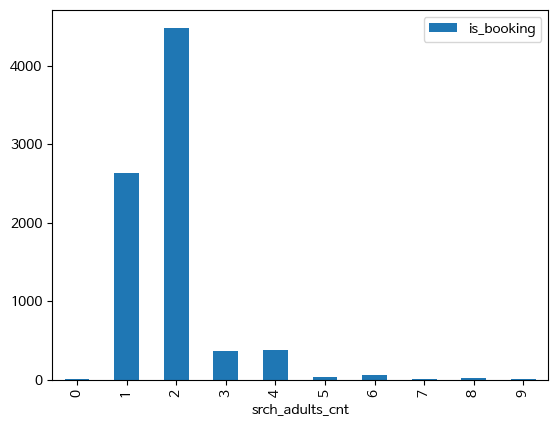

In [8]:
travel_df[['srch_adults_cnt','is_booking']].groupby('srch_adults_cnt').sum().plot(kind='bar')

In [9]:
numerical_columns = travel_df.select_dtypes(['int','float'])
numerical_columns = [i for i in numerical_columns]

numerical_columns

['site_name',
 'posa_continent',
 'user_location_country',
 'user_location_region',
 'user_location_city',
 'orig_destination_distance',
 'user_id',
 'is_mobile',
 'is_package',
 'channel',
 'srch_adults_cnt',
 'srch_children_cnt',
 'srch_rm_cnt',
 'srch_destination_id',
 'srch_destination_type_id',
 'is_booking',
 'cnt',
 'hotel_continent',
 'hotel_country',
 'hotel_market',
 'hotel_cluster']

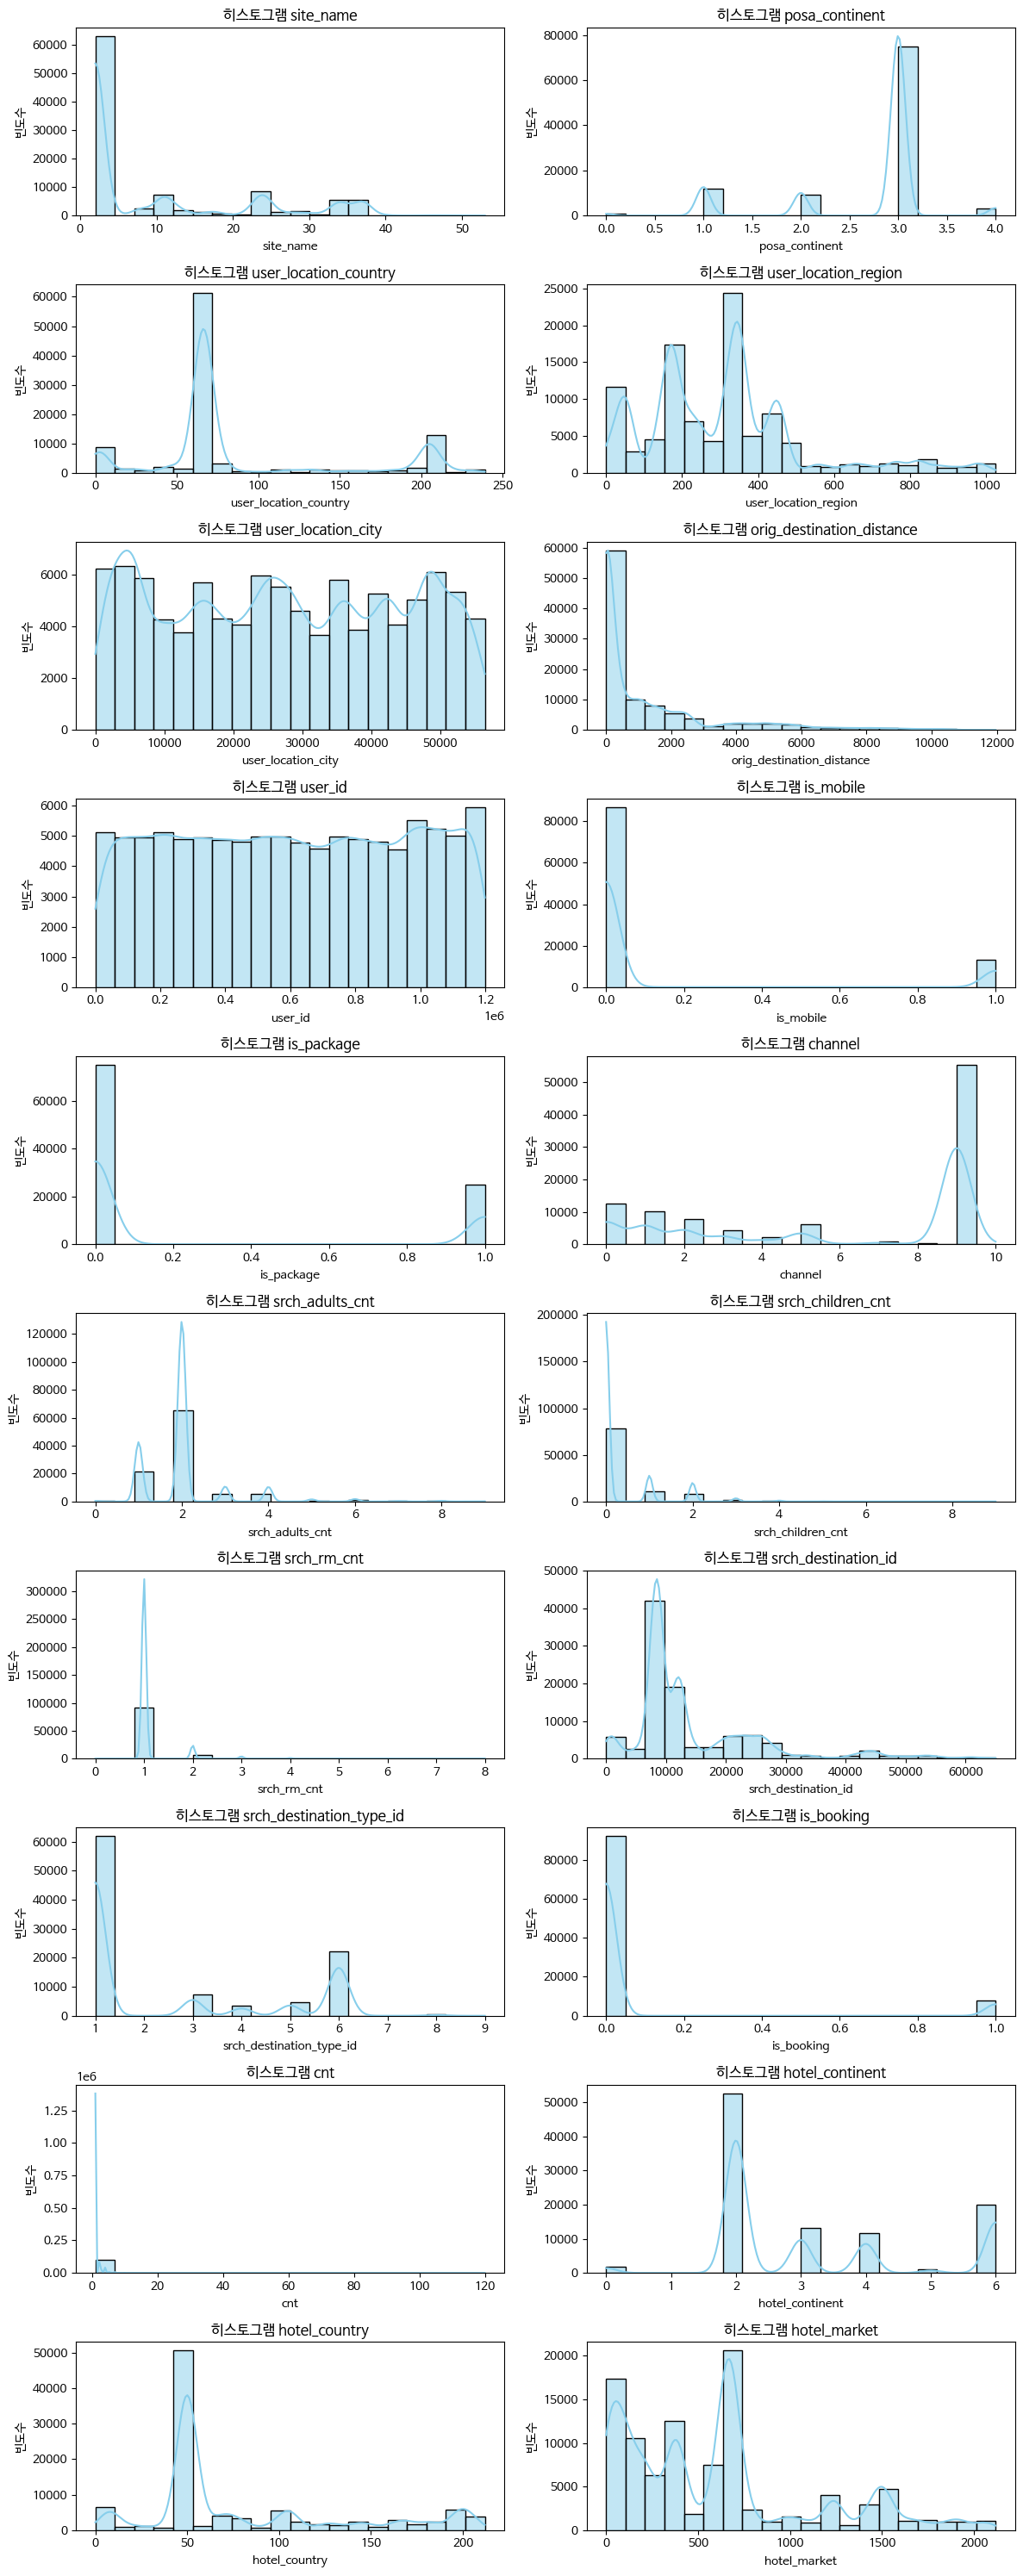

In [10]:

plt.figure(figsize=(12, 30))
for i, col in enumerate(numerical_columns, 1):
    if i>20:
      break
    plt.subplot(10, 2, i)  # 3 rows and 2 columns
    sns.histplot(travel_df[col], kde=True, bins=20, color='skyblue', edgecolor='black')
    plt.title(f'히스토그램 {col}')
    plt.xlabel(col)
    plt.ylabel('빈도수')

plt.tight_layout()
plt.show()

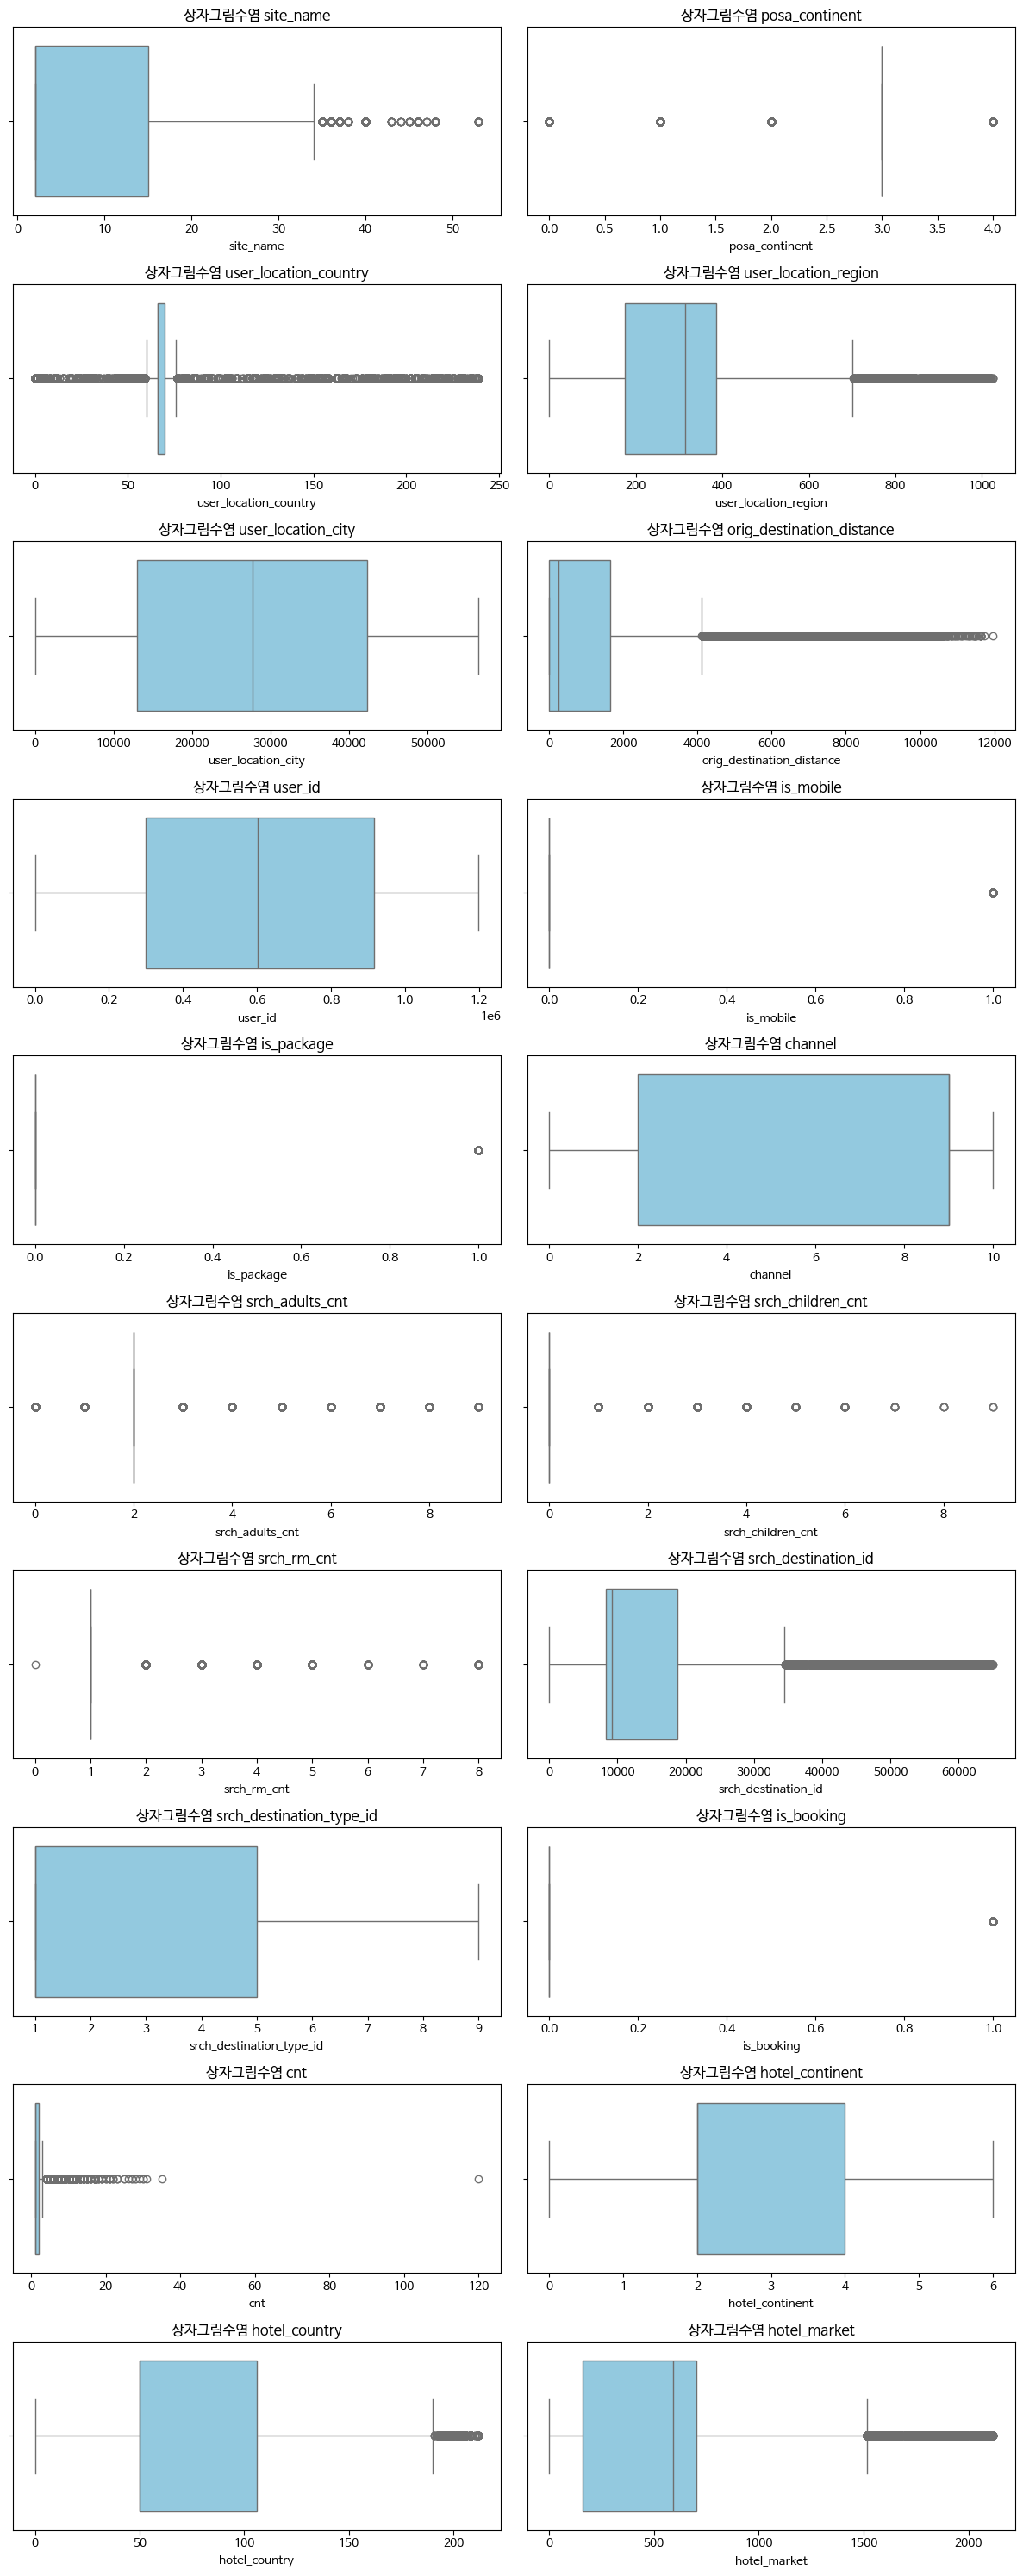

In [11]:
plt.figure(figsize=(12, 30))
for i, col in enumerate(numerical_columns, 1):
    if i>20:
      break
    plt.subplot(10, 2, i)  # 3 rows and 2 columns
    sns.boxplot(x=travel_df[col], color='skyblue')
    plt.title(f'상자그림수염 {col}')
    plt.xlabel(col)


plt.tight_layout()
plt.show()

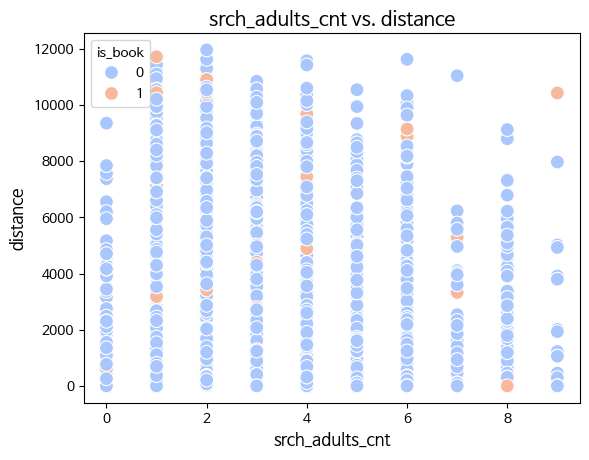

In [12]:
#1. distance vs srch_aults_cnt
plt.figure()
sns.scatterplot(data=travel_df, x='srch_adults_cnt', y='orig_destination_distance', hue='is_booking', palette='coolwarm', s=100)
plt.title('srch_adults_cnt vs. distance', fontsize=14)
plt.xlabel('srch_adults_cnt', fontsize=12)
plt.ylabel('distance', fontsize=12)
plt.legend(title='is_book')
plt.show()

In [13]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler


# 2. 특징과 타겟 변수 분리
X = travel_df.drop('is_booking', axis=1)  # 특징 데이터
X = X.drop('date_time',axis=1)
X = X.drop('srch_ci',axis=1)
X = X.drop('srch_co',axis=1)


y = travel_df['is_booking']  # 타겟 변수

# 3. 데이터 분할 (훈련 및 테스트)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. 랜덤 포레스트 모델 생성 및 훈련
rf_model = RandomForestClassifier(n_estimators=100, random_state=42) # n_estimators는 트리 개수
rf_model.fit(X_train, y_train)

# 5. 예측
y_pred = rf_model.predict(X_test)

# 6. 모델 평가
accuracy = accuracy_score(y_test, y_pred)
print(f"정확도: {accuracy}")

print(classification_report(y_test, y_pred))




정확도: 0.9192
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     18395
           1       0.08      0.00      0.00      1605

    accuracy                           0.92     20000
   macro avg       0.50      0.50      0.48     20000
weighted avg       0.85      0.92      0.88     20000



In [14]:

# 그냥 확인하기에 피쳐종류가 30개나 되어 한눈에 들어오지 않는다.
print(rf_model.feature_importances_, '\n')

# 시리즈로 만들어 인덱스를 붙인다
ser = pd.Series(rf_model.feature_importances_, index=X_train.columns)

# 내림차순 정렬을 이용한다
top_feature = ser.sort_values(ascending = False)

[0.02322731 0.01048818 0.03395751 0.08930909 0.11787712 0.0963776
 0.13175313 0.00970174 0.00730983 0.03450536 0.0224585  0.02089371
 0.0097499  0.10378016 0.02056969 0.02732002 0.0133893  0.03329275
 0.09329958 0.10073953] 



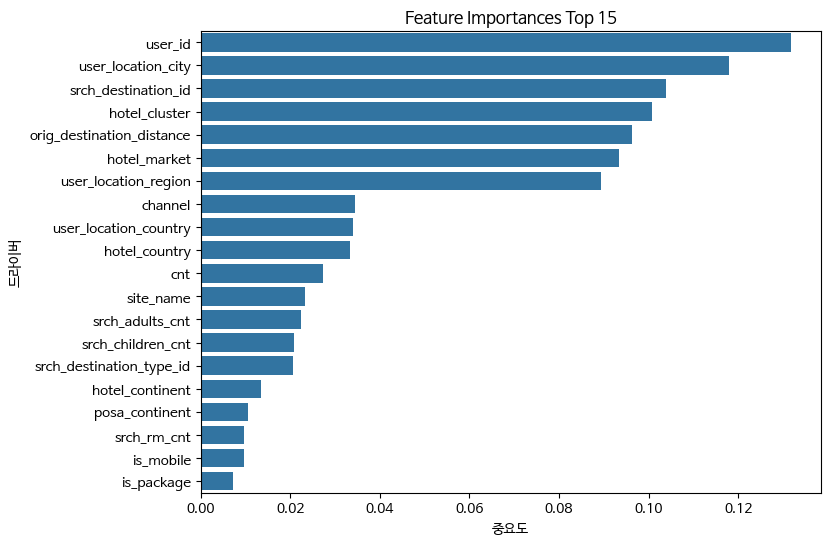

In [15]:
plt.figure(figsize=(8,6))
plt.title('Feature Importances Top 15')
sns.barplot(x=top_feature, y=top_feature.index)
plt.xlabel("중요도")
plt.ylabel("드라이버")

plt.show()

In [16]:
count_Des=travel_df['hotel_cluster'].value_counts().head(10)

<ipython-input-17-3c8ceee5a747>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=count_Des.values,y=count_Des.index,palette="viridis")


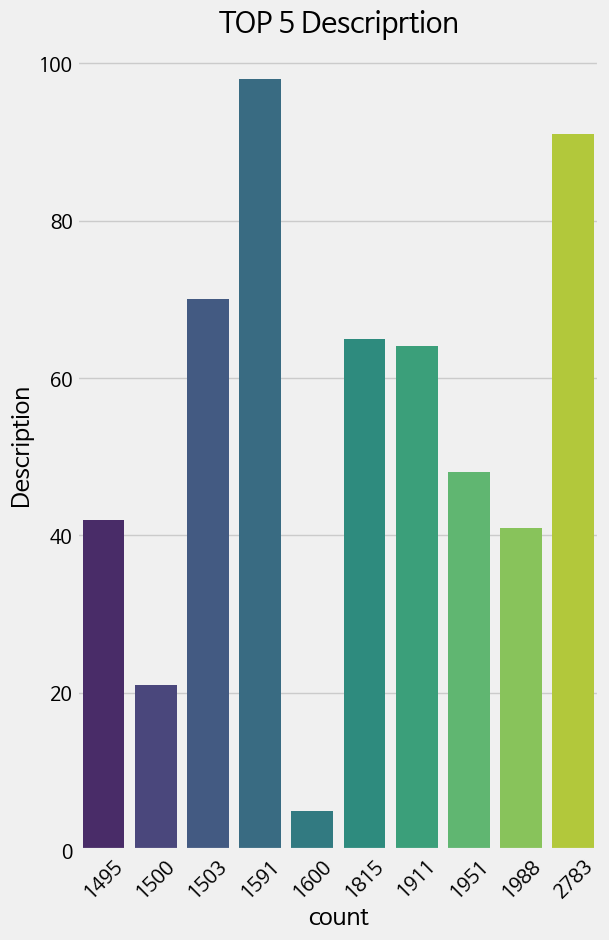

In [17]:
plt.style.use("fivethirtyeight")
plt.figure(figsize=(6,10))
sns.barplot(x=count_Des.values,y=count_Des.index,palette="viridis")
plt.title("TOP 5 Descriprtion")
plt.ylabel("Description")
plt.xlabel("count")
plt.xticks(rotation=45)
plt.show()

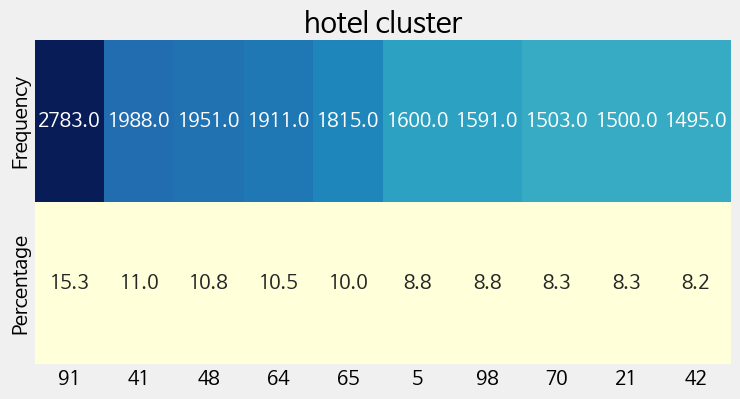

In [18]:

percentage= round((count_Des/count_Des.sum())*100,1)
freqTable = pd.DataFrame({'Frequency':count_Des,'Percentage':percentage})

plt.figure(figsize=(8, 4))
sns.heatmap(freqTable.T, annot=True, fmt=".1f", cmap="YlGnBu", cbar=False)
plt.title("hotel cluster")
plt.xlabel('')
plt.show()

<Axes: xlabel='hotel_cluster', ylabel='count'>

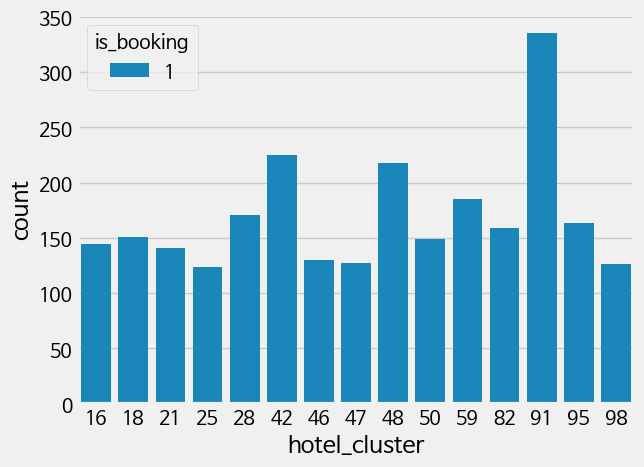

In [19]:
# hue 옵션 사용
travel_df_1 = travel_df[travel_df['is_booking']==1]
df = travel_df_1[['hotel_cluster','is_booking']].value_counts().sort_values(ascending=False).reset_index()
df=df.head(15)
sns.barplot(data=df, x="hotel_cluster", y="count" ,hue="is_booking")

In [20]:
cnt_all = travel_df["hotel_cluster"].value_counts()

count_cnt = travel_df[travel_df["is_booking"]==1]
cnt_cluster = count_cnt["hotel_cluster"].value_counts()

cnt_merge = pd.merge(cnt_all,cnt_cluster,on="hotel_cluster")
cnt_merge

,count_x,count_y
hotel_cluster,,
91,2783,335
41,1988,111
48,1951,218
64,1911,120
65,1815,69
...,...,...
35,338,19
53,334,14
27,267,5


In [21]:
cnt_merge["percentage"] = cnt_merge['count_y']/cnt_merge['count_x']*100

cnt_merge=cnt_merge.sort_values(by='percentage', ascending=False)

cnt_merge = cnt_merge.head(10)

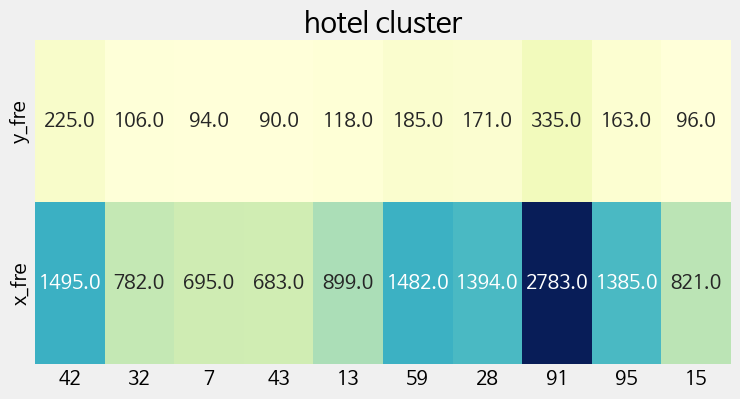

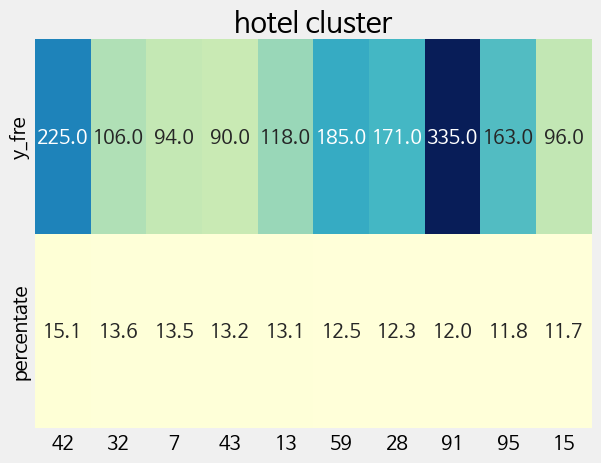

In [22]:

freqTable = pd.DataFrame({'y_fre':cnt_merge["count_y"],'x_fre':cnt_merge["count_x"]})
freqPertable = pd.DataFrame({'y_fre':cnt_merge["count_y"],'percentate':cnt_merge["percentage"]})

plt.figure(figsize=(8, 4))
sns.heatmap(freqTable.T, annot=True, fmt=".1f", cmap="YlGnBu", cbar=False)
plt.title("hotel cluster")
plt.xlabel('')
plt.show()

sns.heatmap(freqPertable.T, annot=True, fmt=".1f", cmap="YlGnBu", cbar=False)
plt.title("hotel cluster")
plt.xlabel('')
plt.show()